# Similarités entre séries

_recherche d'une mesure de similarité pertinente, associée à une feature representation pertinente_

_ismael Bonneau & issam Benamara_

### Principe:

-------------------------------

### Notre but:

-------------------------------

### Données:

Nous partons d'une base de 3369 séries tv. Ces séries contiennent chacune une seule ou plusieurs saisons, qui contiennent un seul ou plusieurs épisodes. Ces épisodes sont représentés par leurs **sous-titres** en anglais. Les mesures de similarité entre séries se baseront donc sur leurs **sous-titres**.

In [7]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import seaborn as sns
#using https://github.com/amueller/word_cloud
from wordcloud import WordCloud

from utils.load_data import getMostImportantSeries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use('seaborn-white')
%matplotlib inline

#dataset path
path = "/root/Documents/PLDAC/dataset"

In [8]:
#pour rendre le notebook plus clean!
def printMatrice(sim, series):
    plt.figure(figsize=(10,10))
    plt.imshow(sim, cmap='YlGn', interpolation='nearest')
    plt.xticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series], rotation='vertical')
    plt.yticks(range(len(corpus)), [" ".join(x.split("_")[1:]) for x in series])
    plt.show()
def krecommendations(sim, series, serie, k):
    print("series les plus proches de {}:".format(" ".join(serie.split("_")[1:])))
    mdr = [(series[i], a) for i, a in enumerate(sim[series.index(serie)])]
    for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:k]]:
        print("  ", " ".join(b))

Reprenons notre liste de séries célèbres, étoffée cette fois-ci: la liste contient **44 séries de plusieurs genres différents**, triés de manière à former des "blocs" de séries du même genre.

In [9]:
series = ['2733_NCIS__Los_Angeles', '2956_Criminal_Minds', '1041_CSI__Crime_Scene_Investigation', '1910_NCIS',
 '1830_CSI__Miami', '207_Bones', '2212_The_Mentalist', '2767_The_Blacklist', '413_Dexter', '1845_Sherlock_(2010)',
 '884_The_X-Files', '3259_Stargate_SG-1', '381_Star_Trek__The_Next_Generation', '2120_Doctor_Who_(1963)',
 '2091_Star_Trek__Deep_Space_Nine', '384_Twilight_Zone', '186_Doctor_Who', '25_Friends', '1704_Rick_and_Morty',
 '2469_The_Simpsons', '2556_The_Big_Bang_Theory', '292_Modern_Family', '1718_South_Park', '95_How_I_Met_Your_Mother',
 '3012_Grey_s_Anatomy', '2261_Buffy_The_Vampire_Slayer', '175_The_Walking_Dead', '1262_Lost', '1039_Narcos',
 '818_Gomorra_(2014)', '2123_Sense8', '3280_Peaky_Blinders', '121_Suits', '76_Breaking_Bad', '217_Game_of_Thrones',
 '2567_House', '1701_Outlander', '2936_Desperate_Housewives', '2053_Charmed', '345_Dallas', '1641_Pretty_Little_Liars',
 '3314_Shameless', '1906_The_Vampire_Diaries', '196_Smallville']

print(len(series))

44


In [10]:
corpus = []

for serie in series:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + file.read()
    corpus.append(text)
print(len(corpus))

44


### Matrice de similarité:

Pour indiquer la ressemblance entre deux séries, nous construire une matrice de similarité. Une matrice de similarité de ${n}$ éléments est tout simplement une matrice ${M}$ de dimension ${n\times n}$ ou l'élément ${M_{i,j}}$ indique la similarité entre l'élément numéro ${i}$ et l'élément numéro ${j}$. Une telle matrice est une représentation graphique agréable, mais peut devenir lourde à maintenir en mémoire quand ${n}$ devient grand.

ci-dessous, un exemple de matrice de similarité avec ${n = 4}$ entre les items A, B, C, D. La diagonale remplie de 1 correspond au fait que chaque élément est identique à lui même, donc totalement similaire.

<img src="images/simmatrix.png" width="" />

#### ... avec une mesure de similarité:

Une mesure de similarité très adaptée au cas des vecteurs sparse est le produit cosinus, ou similarité cosinus.

<img src="images/cosinesim.png" />

La similarité cosinus de deux vecteurs est simplement leur produit scalaire, divisé par le produit de leurs normes (il existe aussi une version sans division par le produit des normes). Il s'agit d'une mesure de similarité très appropriée aux vecteurs contenant beaucoup de valeurs nulles ("sparse"), et convient donc ici particulièrement.
Elle correspond en fait au cosinus de l'angle formé par les deux vecteurs: si les deux vecteurs sont très similaires, l'angle qu'ils forment aura un cosinus proche de 1 car ${\cos{0} = 1}$. Dans le cas où les deux vecteurs sont sans relation, c'est à dire orthogonaux, leur angle sera proche de 90 degrés et son cosinus vaudra 0. Enfin, si les deux vecteurs sont similaires mais opposés, l'angle qu'il forment sera proche de 180 degrés et son cosinus tendra vers -1.

<img src="images/cosinesimilarityfq1.png"/>

#### ... Sur quelles données?

Reste à choisir comment représenter les séries. Ici, notre représentation sera faite à partir de vecteurs bag-of-words (sac de mots). La représentation bag of words est est une représentation dans laquelle on considère un dictionnaire de mots (ensemble de mots) qui peuvent servir à représenter n'importe quel document. Un document est alors représenté par un vecteur de la même taille que le dictionnaire, où la composante ${i}$ de ce vecteur correspond au nombre d'occurence du ${i}$ème mot du dictionnaire.

Par exemple, avec la phrase "the dog is on the table" et le dictionnaire {"are", "cat", "dog", "is", "now", "on", "table", "the"}:

<img src="images/bow.png" width="300" />

Par ailleurs, le texte est lemmatisé au préalable: cela signifie que tous les mots sont mis sous une forme standard, sans flexion. Il n'y a donc plus de pluriel, plus de temps grammatical, de participe passé... cela constitue un prétraitement efficace pour réduire la taille du dictionnaire.

exemple:

| **mot**      |     **lemme**    |
| ------------- |: -------------: |
| happy, happiness, happy      |        happy       |
|   playing, played, plays      |        play        |
| am, are, is      |        be        |

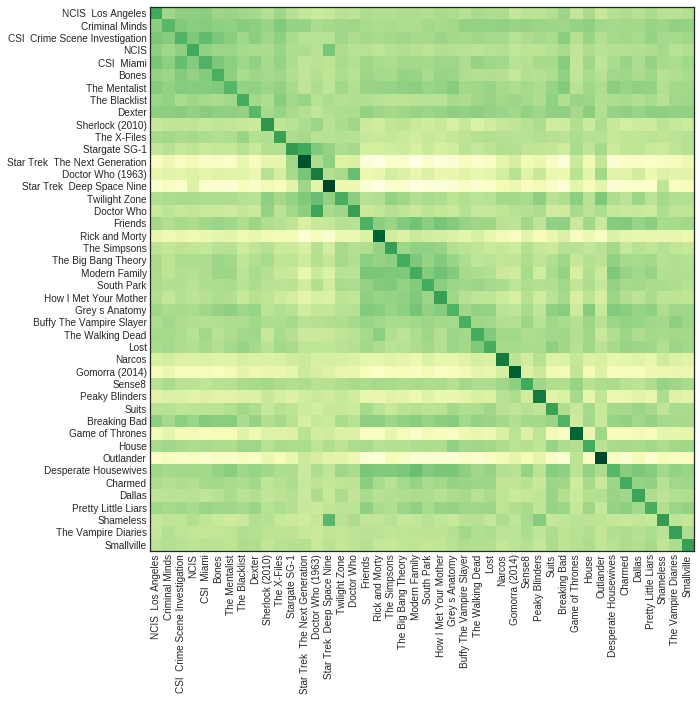

In [11]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)
sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)
printMatrice(sim, series)

In [12]:
krecommendations(sim, series, '2956_Criminal_Minds', 7)
krecommendations(sim, series, '2567_House', 7)
krecommendations(sim, series, '2469_The_Simpsons', 7)
krecommendations(sim, series, '381_Star_Trek__The_Next_Generation', 7)
krecommendations(sim, series, '196_Smallville', 7)

series les plus proches de Criminal Minds:
   Criminal Minds
   CSI  Crime Scene Investigation
   The X-Files
   The Blacklist
   CSI  Miami
   NCIS  Los Angeles
   NCIS
series les plus proches de House:
   House
   Grey s Anatomy
   Suits
   Dexter
   The Blacklist
   The Walking Dead
   Smallville
series les plus proches de The Simpsons:
   The Simpsons
   Modern Family
   South Park
   Rick and Morty
   How I Met Your Mother
   The Big Bang Theory
   Desperate Housewives
series les plus proches de Star Trek  The Next Generation:
   Star Trek  The Next Generation
   Star Trek  Deep Space Nine
   Stargate SG-1
   Doctor Who (1963)
   Outlander
   Game of Thrones
   Gomorra (2014)
series les plus proches de Smallville:
   Smallville
   Pretty Little Liars
   Charmed
   Suits
   The Vampire Diaries
   House
   The Blacklist


#### Résultat:

Ce modèle parait également à première vue très bon, du moins pour les 5-6 premières recommendations.

Essayons l'approche vecteur de tf-idf, en réglant le DF minimum afin de retirer du corpus les mots trop particuliers à une série, en vue d'étudier son impact sur la similarité:

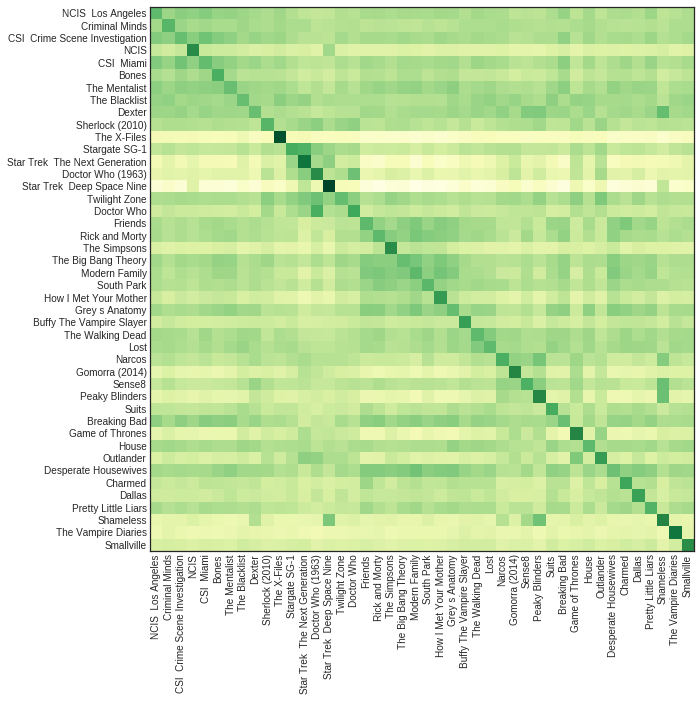

In [13]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=1000, min_df=3)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)
sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

printMatrice(sim, series)

In [14]:
krecommendations(sim, series, '2956_Criminal_Minds', 7)
krecommendations(sim, series, '2567_House', 7)
krecommendations(sim, series, '2469_The_Simpsons', 7)
krecommendations(sim, series, '381_Star_Trek__The_Next_Generation', 7)
krecommendations(sim, series, '196_Smallville', 7)

series les plus proches de Criminal Minds:
   Criminal Minds
   CSI  Crime Scene Investigation
   The Blacklist
   CSI  Miami
   The X-Files
   NCIS  Los Angeles
   House
series les plus proches de House:
   House
   Grey s Anatomy
   Suits
   The Walking Dead
   The Blacklist
   Pretty Little Liars
   Criminal Minds
series les plus proches de The Simpsons:
   The Simpsons
   Modern Family
   Rick and Morty
   South Park
   How I Met Your Mother
   The Big Bang Theory
   Desperate Housewives
series les plus proches de Star Trek  The Next Generation:
   Star Trek  The Next Generation
   Star Trek  Deep Space Nine
   Stargate SG-1
   Doctor Who (1963)
   Outlander
   Game of Thrones
   Gomorra (2014)
series les plus proches de Smallville:
   Smallville
   Pretty Little Liars
   Suits
   Charmed
   House
   The Blacklist
   Lost


#### Résultat:

On remarque la présence d'un carré assez sombre en haut à gauche: le modèle a reconnu une certaine similarité entre les séries de type "policier" comme esprits criminels, ou NCIS. Un autre "carré" est aussi présent dans l'image, qui correspond à une certaine similarité entre les séries dites "comiques" comme les simpsons, modern family, south park... un bloc "science-fiction" est aussi présent.

On remarque que le modèle devient mauvais à partir de la 5e recommendation environ: la base de test est trop petite pour permettre de recommender autant de séries.

Etant donné la proximité des résultats des 2 modèles, un problème se pose:

>Comment évaluer la qualité d'un modèle de similarité?

Nous devons utiliser une ou plusieurs mesures de similarité pour évaluer qualitativement nos modèles, afin d'être en mesure de choisir le meilleur.

Dans un premier temps, nous évaluons les performances d'une recommendation en calculant une moyenne de ses scores de rappel, précision, et mesure F1. Une façon de définir les "séries pertinentes" que le système devrait théoriquement prédire est de se baser sur le genre des séries.

#### Les genres des séries nous sont donnés par l'api TVdb:

In [15]:
series_df = pd.read_csv("series.csv")
series_df = series_df.dropna(subset=["genres"])
series = list(series_df["seriesname"])
series_df[["seriesname", "genres"]].head(3)

,seriesname,genres
0,2318_Raising_the_Bar,Drama
1,1159_Rejseholdet_(Unit_One),Drama
2,1821_Til_Death,Comedy


calculons la matrice de similarité de 1000 séries, puis évaluons les performances:

In [16]:
corpus = []
for serie in series_df["seriesname"]:
    listepisodes = glob.glob(path+"/"+serie+"/*/*.tokens")
    text = ""
    for episode in listepisodes:
        with open(episode, "r", encoding="utf-8") as file:
            text += " " + file.read()
    corpus.append(text)
print(len(corpus))

939


In [17]:
customstopwords = stopwords.words('english') + ["yes","hmm","nah","oh","uh",
                                                "ye","na","ca","ok","got","come","back","up"]

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=3, max_features=2000, stop_words=customstopwords)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)

In [18]:
sim = cosine_similarity(vec)
p = series.index('2469_The_Simpsons')

mdr = sorted([(series[i], a) for i, a in enumerate(sim[p])], key=lambda x: x[1], reverse=True)
for a, e in mdr[:25]:
    print("  ", " ".join(a.split("_")[1:]), "\t\t\t\t ", list(series_df[series_df["seriesname"]==a]["genres"])[0])

   The Simpsons 				  Animation-Comedy
   Duckman 				  Animation-Comedy
   Malcolm In The Middle 				  Comedy
   Futurama 				  Animation-Comedy-Science-Fiction
   Mike Molly 				  Comedy
   Raising Hope 				  Comedy
   The Cleveland Show 				  Animation-Comedy
   Just Shoot Me 				  Comedy
   MacGyver 				  Action-Adventure
   Veronica Mars 				  Crime-Drama
   30 Rock 				  Comedy
   American Horror Story 				  Drama-Horror-Thriller
   Scrubs 				  Comedy
   The Critic 				  Animation-Comedy
   Phineas and Ferb 				  Animation-Children-Comedy
   The Suite Life on Deck 				  Action-Adventure-Comedy
   Mork and Mindy 				  Comedy-Science-Fiction
   BoJack Horseman 				  Animation-Comedy-Drama
   The Suite Life of Zack Cody 				  Adventure-Comedy-Family
   Voyagers 				  Action-Adventure-Fantasy
   Frasier 				  Comedy
   Desperate Housewives 				  Comedy-Drama-Soap
   Cougar Town 				  Comedy
   Lost Girl 				  Crime-Drama-Fantasy-Horror
   Hot in Cleveland 				  Comedy


Sur cet exemple sur la série "Les Simpsons", on voit que le système a recommendé plusieurs séries dont le genre n'a rien à voir avec les simpsons: American Horror Story, MacGyver (MacGyver ressemble aux simpsons, vraiment?!), Lost girl, Voyagers, Desperate housewifes...

L'ensemble de métriques précision/rappel/F1 fournit une mesure pertinente: la **précision**. En mesurant la précision, nous évaluons la probabilité **qu'une série recommendée soit une série du même genre**.
Le **rappel**, quant à lui, mesure la probabilité **qu'une série du même genre soit recommendée**.

Le score F1, quant à lui, est la moyenne géométrique de la précision et du rappel:

<img src="images/f1-score.jpg" width="250"/>

Nous chercherons à évaluer les performances de nos modèles en considérant comme référence à recommender les **séries du même genre**. Nous prendrons deux références pour une série A: 
- les séries qui ont tous les genres de A: par exemple, si A est du genre action-aventure, nous considérons les séries qui appartiennent toutes au genre action-aventure.
- les séries qui ont un genre en commun avec A: par exemple, si A est du genre action-aventure, toutes les séries qui sont sont action, soit aventure.

In [19]:
#classe implémentant les mesures de rappel/précision/score F1
from utils.evalIRmodel import EvalIRmodel

Construisons la liste des séries pertinentes en terme de similarité pour chaque série: Commencons par les séries du même genre:

In [20]:
import warnings
warnings.filterwarnings(action='once')

pertinent = []

for i, row in series_df.iterrows():
    lol = row["genres"]
    regexp = ".*"
    genres = []
    if lol.find("Science-Fiction") != -1:
        lol = lol.replace("Science-Fiction", "")
        lol = lol.replace("--", "-")
        genres.append("Science-Fiction")
    genres += row["genres"].split("-")
    for i in range(len(genres) - 1):
        regexp += "("+"|".join(genres)+"){1}.*-"
    regexp += "("+"|".join(genres)+"){1}.*"
    pertinent.append(list(series_df[series_df["genres"].str.match(regexp)]["seriesname"]))

Et maintenant, passons à l'évalutation:

In [21]:
similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([a for a, b in mdr])

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

precision: 0.356
rappel: 0.246
F1: 0.087


Avec un modèle à base de bag of words:

In [22]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)

sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([a for a, b in mdr])

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


precision: 0.350
rappel: 0.249
F1: 0.090


### comparons avec une autre méthode d'évaluation:

In [23]:
pertinent = []

for i, row in series_df.iterrows():
    lol = row["genres"]
    regexp = ".*"
    genres = []
    if lol.find("Science-Fiction") != -1:
        lol = lol.replace("Science-Fiction", "")
        lol = lol.replace("--", "-")
        genres.append("Science-Fiction")
    genres += lol.split("-")
    regexp = "("+"|".join(genres)+")"
    pertinent.append(list(series_df[series_df["genres"].str.match(regexp)]["seriesname"]))

In [24]:
counter_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
x = counter_vect.fit(corpus)
vec = counter_vect.transform(corpus)

sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([a for a, b in mdr])

evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


precision: 0.592
rappel: 0.033
F1: 0.037


In [25]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', min_df=3, max_features=2000, stop_words=customstopwords)
x = tfidf_vect.fit(corpus)
vec = tfidf_vect.transform(corpus)

sim = cosine_similarity(vec)
sim = normalize(sim, norm='l1', axis=0)

similaires = []
for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([a for a, b in mdr])

evaluations = evaluation.evaluate(similaires, pertinent, k=10)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

/root/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


precision: 0.582
rappel: 0.033
F1: 0.036


# Approche Embeddings

# Similarités entre séries ( Word Embeddings )

#### - utilisation de word embeddings avec tf-idf pour trouver une mesure de similarité entre les différentes séries

## Principe

Dans ce qui suis nous utiliserons le terme "Document" pour dire "Série". Vu que l'on considère une série comme la concaténation de tous les sous titres de tous ses épisodes, et donc comme un long document.

Pour le calcul de similarité entre les documents, nous allons suivre la même méthode qu'avant :
- représenter un document par un vecteur
- utiliser des mesures de distance pour calculer la similarité entre deux vecteurs ( deux documents )

Ceci servira comme base pour faire un clustering de "genre" ou de "style" des documents.
Nous allons pour un début tester juste une combinaison de possibilités:
- démarrer à partir des vecteurs tf-idf des documents
- vecteurs word embedding généré par Word2vec
- distance de mesure : cosinus

### Word embedding ? 
Pour le définir rapidement, on peut dire que pour chaque mot du corpus on va avoir un vecteur de réels de taille fixe qui représentera d'une manière ou d'une autre le mot.

Et comme par magie des opérations vectoriels entre des mots ( vecteurs de réels ) nous donnes des mesures de similarités plutot correctes ! au lieu d'utiliser simplement tf-idf qui sont des vecteurs sparse.

Pour générer ces vecteurs nous allons utiliser Word2Vec entrainé sur le corpus entier, c'est à dire un gros fichier text qui contient l'ensemble des mots de tout le corpus.

### Document embedding ?
D'accord on a une représentation vectorielle de chaque mot qui marche comme par magie, mais nous souhaterions avoir une représentation similaire pour chaque document ( afin de mesurer cette similarité par magie aussi ).

Pour cela nous allons utiliser un simple principe:
- Soit V le vecteur représentant un Document lambda ( que ça soit tf-idf par exemple ) de taille N  (N = nombre de mots du vocabulaire ) 
- Soit la taille fixe du vecteur word embedding = p
- Soit la matrice M = N x p , càd N lignes ( N = nombre de mots du vocabulaire ) et p colonnes, ou chaque ligne i est le vecteur word embedding obtenu à partir de word2vec correspondant au ieme mot du vocabulaire
- Le vecteur D représentant le document embedding sera donc simplement :  D = V.M ( biensure on va s'arranger pour que la multiplication se passe bien en alignant les bonnes dimensions )

pour faire facile : le document sera la somme des word embeddings des mots qui le composent ( pondéré par tf-idf dans notre cas )


### Librarie personelle

Nous avons créer une classe qui permet de générer des matrices de similarités pour nos séries en suivant les étapes suivantes :
- Import de notre classe **CustomSim** du fichier **CustomSimilarity.py**
- Spécifier les différents paramètres de word2vec ( nombre de séries, taille du vecteur embedding, fenêtre de mots considérés .. )
- Spécifier un Tokenizer ( Suppression de stop words uniquement, stemming, lemmatizing .. )
- Spécifier un Vectorizer ( Bag of words, Tf-idf .. )
- Spécifier un Combiner, c'est à dire la manière de combiner les informations que l'on a pour obtenir un embedding d'une série
- Spécifier la mesure de similarité ( Cosine .. )

La classe est optimisée de tel sorte à que l'on puisse éviter de refaire des calculs déja fait, tous les calculs intermédiaires sont stockés dans des fichiers.

## Dans notre cas

Nous avons utilisé :
- Suppression de stop words seulement
- Tf-idf
- Somme des embeddings des mots d'une série pondérés par leurs tf-idf
- Mesure de similarité Cosinus

In [27]:
# A régler ultérieurement car ce n'est pas les memes noms de série entre Issam et Ismael
path = "/root/Documents/PLDAC/data"

### Redéfinition de quelques fonctions pour la compatibilité de la matrice

Nous n'avions pas les memes noms pour les séries donc il va falloir redéfinir quelques fonctions pour que le code marche

In [43]:
def krecommendations(sim, series, serie, k):
    print("series les plus proches de {}:".format(" ".join(serie.split("_")[1:])))
    index = 0
    ch = ("".join(serie.split("_")[1:])).lower()
    for j, name in enumerate(series):
        if ch in ("".join(name.split("_"))).lower():
            index = j
            break
    mdr = [(series[i], a) for i, a in enumerate(sim[index])]
    for b in [a.split("_")[1:] for a, e in sorted(mdr, key=lambda x: x[1], reverse=True)[:k+1]][1:]:
        print("  ", " ".join(b))

In [29]:
""" Nous avons calculé les similarités pour 3000 séries en utilisant notre classe """
nbSeries = 3000
seriesNames, _ = getMostImportantSeries(path, byepisodes=True)
series = seriesNames[:nbSeries]
len(series)

3000

#### Ouverture de la matrice calculé préalablement

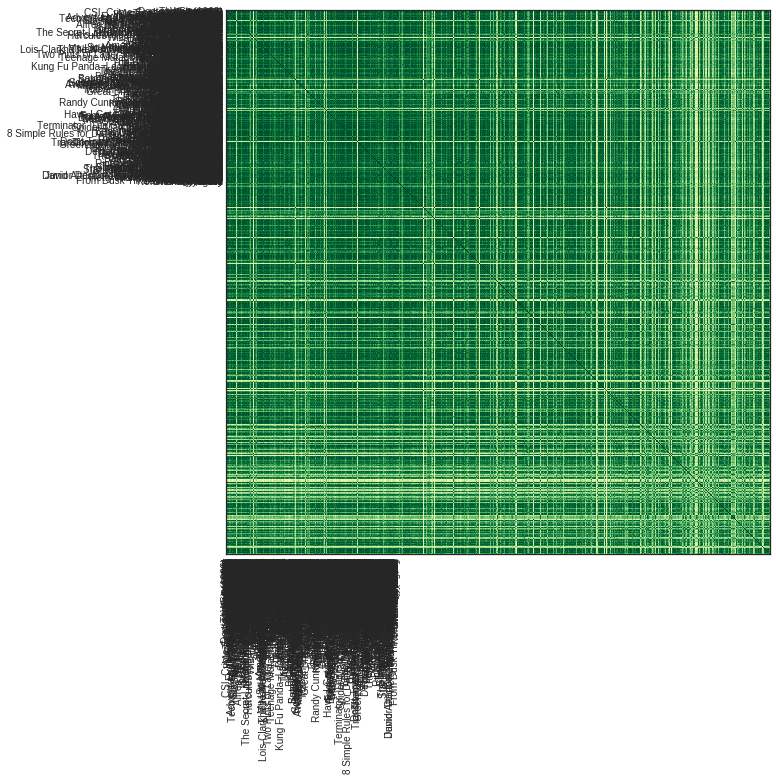

In [54]:
sim = np.load("similarity_matrices/sim_3000.npy")

printMatrice(sim, series)

In [55]:
krecommendations(sim, series, '2956_Criminal_Minds', 7)
krecommendations(sim, series, '_House', 7)
krecommendations(sim, series, '2469_The_Simpsons', 7)
krecommendations(sim, series, '381_Star_Trek__The_Next_Generation', 7)
krecommendations(sim, series, '196_Smallville', 7)

series les plus proches de Criminal Minds:
   Criminal Minds  Suspect Behavior
   Cracked
   Millennium
   Profiler
   Those Who Kill
   Stalker
   Perception
series les plus proches de House:
   Brothers Sisters
   Being Mary Jane
   Mistresses (US)
   The Affair
   Melrose Place
   7th Heaven
   Once and Again
series les plus proches de The Simpsons:
   The Looney Tunes Show (2011)
   The Cleveland Show
   American Dad
   Neighbors From Hell
   Man Up
   Raising Hope
   Bob s Burgers
series les plus proches de Star Trek  The Next Generation:
   Star Trek
   Star Trek Continues
   Star Trek  The Animated Series
   Star Trek  Enterprise
   Star Trek  Voyager
   Star Trek  Deep Space Nine
   Blake s 7
series les plus proches de Smallville:
   Lois Clark  The New Adventures of Superman
   Heroes
   The Tomorrow People (US)
   The 4400
   Birds of Prey
   Terminator  The Sarah Connor Chronicles
   The Messengers


Nous remarquons que les séries les plus similaires ont l'air d'être très très proches intuitivement

### Considérons les séries avec notes

In [32]:
series_df = pd.read_csv("series.csv")
series_df = series_df.dropna(subset=["genres"])
"""
J'AI CONTINUÉ À UTILISER LA VARIABLE SERIES, DONC ON L'ECRASE PAS
"""
#series = list(series_df["seriesname"])
series_df[["seriesname", "genres"]].head(3)

,seriesname,genres
0,2318_Raising_the_Bar,Drama
1,1159_Rejseholdet_(Unit_One),Drama
2,1821_Til_Death,Comedy


In [56]:
"""
Les résultats ne sont pas les mêmes car ici on prend en compte que la série doit être présente dans les
séries qui ont été notés
"""

serie = '_House'
index = None
ch = ("".join(serie.split("_")[1:])).lower()
for j, name in enumerate(series):
    x = ("".join(name.split("_")[1:])).lower()
    if ch == x:
        index = j
        break
p = index
mdr = sorted([(series[i], a) for i, a in enumerate(sim[p])], key=lambda x: x[1], reverse=True)

series_genres = list(series_df["seriesname"])

for a, e in mdr[:25]:
    realName = None
    ch = "".join(a.split("_")[1:])
    for j, name in enumerate(series_df["seriesname"]):
        x = "".join(name.split("_")[1:])
        if ch in x:
            realName = name
            break
    if realName is None:
        continue
    print("  ", " ".join(a.split("_")[1:]), "\t\t\t\t ", list(series_df[series_df["seriesname"]==realName]["genres"])[0])

   House 				  Comedy-Drama
   Remedy 				  Drama
   Grey s Anatomy 				  Drama-Romance-Soap
   ER 				  Drama
   Saving Hope 				  Drama-Fantasy
   Mental 				  Crime-Drama-Mystery
   Regenesis 				  Drama-Science-Fiction-Thriller
   Private Practice 				  Drama-Soap
   Junior Doctors  Your Life In Their Hands 				  Documentary


Construisons la liste des séries pértinentes pour chaque série

In [47]:
import warnings
warnings.filterwarnings(action='once')

pertinent = []

introuvables = []
cleaned = False #juste pour ne pas supprimer plusieurs fois les introuvables
for i, serie in enumerate(series):
    index = None
    ch = "".join(serie.split("_")[1:])
    for j, name in enumerate(series_df["seriesname"]):
        x = "".join(name.split("_")[1:])
        if ch in x:
            index = j
            break
    if index is None:
        introuvables.append(i)
        continue
        
    row = series_df.iloc[index]
    lol = row["genres"]
    regexp = ".*"
    genres = []
    if lol.find("Science-Fiction") != -1:
        lol = lol.replace("Science-Fiction", "")
        lol = lol.replace("--", "-")
        genres.append("Science-Fiction")
    genres += row["genres"].split("-")
    for i in range(len(genres) - 1):
        regexp += "("+"|".join(genres)+"){1}.*-"
    regexp += "("+"|".join(genres)+"){1}.*"
    neat = []
    for name in list(series_df[series_df["genres"].str.match(regexp)]["seriesname"]):
        tmp = "".join(name.split("_")[1:])
        tmp = tmp.lower()
        neat.append(tmp)
    pertinent.append(neat)

A partir de la matrice de similarités, nous calculons quels sont les séries qui sont les plus similaires à la série choisie

In [48]:
similaires = []

for s in range(len(series)):
    mdr = sorted([(series[i], a) for i, a in enumerate(sim[s])], key=lambda x: x[1], reverse=True)[:30]
    similaires.append([("".join(a.split("_")[1:])).lower() for a, b in mdr])

len(similaires)

3000

On supprime les séries non trouvables parmis celles notés

In [49]:

if not cleaned:
    for k, index in enumerate(introuvables):
        similaires.pop(index-k)
cleaned = True

In [50]:
print(len(similaires),len(pertinent))

982 982


### Evaluation des résultats

In [51]:
evaluation = EvalIRmodel()
evaluations = evaluation.evaluate(similaires, pertinent, k=1)

print("precision: {0:.3f}".format(evaluations["precision"]["mean"]))
print("rappel: {0:.3f}".format(evaluations["recall"]["mean"]))
print("F1: {0:.3f}".format(evaluations["F1"]["mean"]))

precision: 0.828
rappel: 0.220
F1: 0.109


Surprise ! Les performances du système sont considérablement meilleures que d'utiliser tout simplement Bag of words ou bien Tf-idf.

La combinaison entre word2vec et Tf-idf améliore donc notre modèle de similarités

###  Tests avec stemming, lemmatizing ... à venir